In [1]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from IPython.display import display
from keras.models import Model, Sequential
from keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.regularizers import l2
from sklearn.utils import compute_class_weight
from imblearn.over_sampling import SMOTE
%matplotlib inline

Using TensorFlow backend.


In [2]:
def flat(list_):
    list_a = []
    for i in list_:
        list_a.append(i.flatten())
    return list_a

def load_label(path):
    label = pd.read_table(path, sep=',', header=None)
    label.columns=['video','jpg', 'interesting', 'level', 'key_frame']
    label = label.groupby(['jpg'], sort=False, as_index=False).max()
    return label

train_label = load_label('data/devset-image.txt')
test_label = load_label('data/testset-image.txt')

train_label.head(2)

,jpg,video,interesting,level,key_frame
0,107_102-113.jpg,video_0,0,0.099801,36
1,129_114-144.jpg,video_0,0,0.029117,46


In [3]:
# train = np.load('data/train_array.npy')
# train_flat = flat(train)
# y = np.array(train_label['interesting'])

# a=np.array(train_flat)
# y = np.reshape(y, (4942,1))
# new_array = np.hstack((a,y))

# ind = np.argsort(new_array[:,-1])
# new_array = new_array[ind]
# np.save('sorted_array', new_array)

In [4]:
data = np.load('sorted_array.npy')

X,y=data[:,:-1], data[:,-1]

X=X[2000:]
y=y[2000:]

In [5]:
method = SMOTE(kind='regular')
X_res, y_res = method.fit_sample(X, y)

4942 images for training
Counter({0: 2471, 1: 2471})


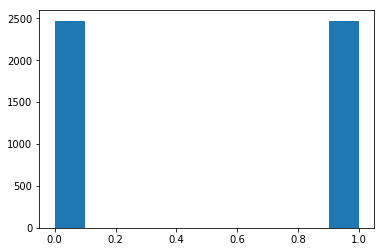

In [6]:
from collections import Counter
print('{} images for training'.format(len(y_res)))
print(Counter(y_res))
plt.hist(y_res);

In [7]:
train = X_res.reshape((4942, 216, 384, 3))

In [8]:
# model = Sequential()
# model.add(Conv2D(64, (3, 3), input_shape=(216, 384, 3)))
# model.add(Dropout(0.2))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Dropout(0.5))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Activation('relu'))
# model.add(Dropout(0.9))
# model.add(Dense(2, activation='softmax', W_regularizer=l2(0.5)))
# model.summary()

In [9]:
vgg = VGG19(weights='imagenet', include_top=False, input_shape=(216, 384, 3))

x = Flatten(name='flatten')(vgg.layers[-3].output)
x = Dense(2, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg.input, outputs=x)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 216, 384, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 216, 384, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 216, 384, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 108, 192, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 108, 192, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 108, 192, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 54, 96, 128)       0         
__________

In [10]:
for layer in model.layers:
    if layer.name in ['flatten','predictions']:
        continue
    layer.trainable = False

df = pd.DataFrame(([layer.name, layer.trainable] for layer in model.layers), columns=['layer', 'trainable'])
df.style.applymap(lambda trainable: f'background-color: {"white" if trainable else "lightblue"}', subset=['trainable'])

,layer,trainable
0,input_1,False
1,block1_conv1,False
2,block1_conv2,False
3,block1_pool,False
4,block2_conv1,False
5,block2_conv2,False
6,block2_pool,False
7,block3_conv1,False
8,block3_conv2,False
9,block3_conv3,False


In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
             metrics=['accuracy'])

history = model.fit(train, 
                    to_categorical(y_res),
                    validation_split=.1, 
                    epochs=5)

Train on 4447 samples, validate on 495 samples
Epoch 1/5
4447/4447 [==============================] - 4064s - loss: 8.8862 - acc: 0.4446 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 2/5
4447/4447 [==============================] - 4077s - loss: 8.9073 - acc: 0.4443 - val_loss: 1.0960e-07 - val_acc: 1.0000
Epoch 3/5
4416/4447 [============================>.] - ETA: 25s - loss: 8.8972 - acc: 0.4450

KeyboardInterrupt: 

In [24]:
test = np.load('data/test_array.npy')
y_test = np.array(test_label['interesting'])

In [26]:
preds = model.predict(test)

Counter({0: 2274, 1: 40}) 0.88202247191


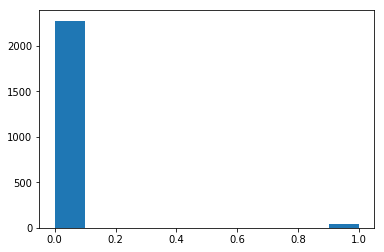

In [28]:
outcome = np.argmax(preds, axis=1)
plt.hist(np.argmax(preds, axis=1))
print(Counter(outcome), sum(outcome==y_test)/len(y_test))
plt.show()

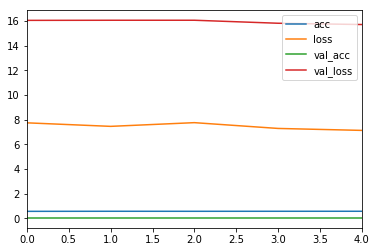

In [34]:
pd.DataFrame(history.history).plot();

In [37]:
confusion_matrix(y_test, outcome)

array([[2037,   36],
       [ 237,    4]])